In [12]:
import os
import requests
import zstandard as zstd
from tqdm import tqdm
import pandas as pd
import random
import shutil
import rasterio
from rasterio.warp import calculate_default_transform
from rasterio.warp import reproject, Resampling
import numpy as np
from PIL import Image
import time
import matplotlib.pyplot as plt

In [28]:
dataset_dir = r'C:\Users\isaac\Desktop\BigEarthTests\OnePBigEarthNetCopy'
subset_dir = r'C:\Users\isaac\Desktop\BigEarthTests\Subsets'
metadata_file = r'C:\Users\isaac\Downloads\metadata.parquet'
unwanted_metadata_file = r'C:\Users\isaac\Downloads\metadata_for_patches_with_snow_cloud_or_shadow.parquet'
    
metadata_df = pd.read_parquet(metadata_file)
snow_cloud_metadata_df = pd.read_parquet(unwanted_metadata_file)

In [34]:
# Check if the labels are strings and need to be converted
if isinstance(DatasetConfig.metadata_csv['labels'].iloc[0], str):
    DatasetConfig.metadata_csv['labels'] = DatasetConfig.metadata_csv['labels'].apply(ast.literal_eval)

# Get unique class labels
class_labels = DatasetConfig.metadata_csv['labels'].explode().unique()

# Create a dictionary mapping class labels to indices
class_labels_dict = {label: idx for idx, label in enumerate(class_labels)}

# Create a reversed dictionary mapping indices to class labels
reversed_class_labels_dict = {idx: label for label, idx in class_labels_dict.items()}

print(class_labels_dict)
print(reversed_class_labels_dict)

{'Arable land': 0, 'Broad-leaved forest': 1, 'Land principally occupied by agriculture, with significant areas of natural vegetation': 2, 'Pastures': 3, 'Urban fabric': 4, 'Complex cultivation patterns': 5, 'Mixed forest': 6, 'Industrial or commercial units': 7, 'Coniferous forest': 8, 'Transitional woodland, shrub': 9, 'Natural grassland and sparsely vegetated areas': 10, 'Inland waters': 11, 'Marine waters': 12, 'Inland wetlands': 13, 'Moors, heathland and sclerophyllous vegetation': 14, 'Permanent crops': 15, 'Agro-forestry areas': 16, 'Beaches, dunes, sands': 17, 'Coastal wetlands': 18}
{0: 'Arable land', 1: 'Broad-leaved forest', 2: 'Land principally occupied by agriculture, with significant areas of natural vegetation', 3: 'Pastures', 4: 'Urban fabric', 5: 'Complex cultivation patterns', 6: 'Mixed forest', 7: 'Industrial or commercial units', 8: 'Coniferous forest', 9: 'Transitional woodland, shrub', 10: 'Natural grassland and sparsely vegetated areas', 11: 'Inland waters', 12: '

In [36]:
# Get the number of images in each DataFrame
num_images_metadata = metadata_df.shape[0]
num_images_snow_cloud_metadata = snow_cloud_metadata_df.shape[0]

print(f"Number of images in metadata_df: {num_images_metadata}")
print(f"Number of images in snow_cloud_metadata_df: {num_images_snow_cloud_metadata}")
print(f"Total number of images: {num_images_metadata + num_images_snow_cloud_metadata}")

Number of images in metadata_df: 480038
Number of images in snow_cloud_metadata_df: 69450
Total number of images: 549488


In [ ]:
def resizeTiffFiles(input_tiff, output_tiff, new_width, new_height):
    with rasterio.open(input_tiff) as src:
        transform, width, height = calculate_default_transform(src.crs, src.crs, new_width, new_height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': src.crs,
            'transform': transform,
            'width': new_width,
            'height': new_height
        })
        with rasterio.open(output_tiff, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=src.crs,
                    resampling=Resampling.nearest
                )

In [ ]:
def resize_tiff_file(input_tiff, output_tiff, new_width=120, new_height=120):
    """Resize a single TIFF file."""
    with rasterio.open(input_tiff) as src:
        transform, width, height = calculate_default_transform(
            src.crs, src.crs, new_width, new_height, *src.bounds)
        
        # Update metadata for new width and height
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': src.crs,
            'transform': transform,
            'width': new_width,
            'height': new_height
        })
        
        # Write directly to the output file
        with rasterio.open(output_tiff, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=src.crs,
                    resampling=Resampling.nearest
                )

In [44]:
def createSubsets(dataset_dir, subsets, metadata_df, subset_dir):
    metadata_50 = pd.DataFrame(columns=metadata_df.columns)
    metadata_10 = pd.DataFrame(columns=metadata_df.columns)
    metadata_1 = pd.DataFrame(columns=metadata_df.columns)

    for subset in subsets.values():
        if not os.path.exists(subset):
            os.makedirs(subset)
            print(f"Created subset: {subset}")
        else:
            print(f"Subset already exists: {subset}")
    
    for folder in tqdm(os.listdir(dataset_dir), desc='Creating subsets'):
        folder_path = os.path.join(dataset_dir, folder)

        if os.path.isdir(folder_path):
            # List all subfolders
            subfolders = [f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f))]

            # Calculate number of folders in each subset
            num_subfolders = len(subfolders)
            num_50_percent = min(max(1, num_subfolders // 2), num_subfolders)
            num_10_percent = min(max(1, num_subfolders // 10), num_subfolders)
            num_1_percent = min(max(1, num_subfolders // 100), num_subfolders)

            # Select random subfolders for each subset
            selected_50 = random.sample(subfolders, num_50_percent)
            selected_10 = random.sample(subfolders, num_10_percent)
            selected_1 = random.sample(subfolders, num_1_percent)

            # Filter metadata for each subset
            metadata_50 = pd.concat([metadata_50, metadata_df[metadata_df['patch_id'].isin(selected_50)]])
            metadata_10 = pd.concat([metadata_10, metadata_df[metadata_df['patch_id'].isin(selected_10)]])
            metadata_1 = pd.concat([metadata_1, metadata_df[metadata_df['patch_id'].isin(selected_1)]])

            # Copy selected subfolders to each subset directory
            for selected in selected_50:
                dest_path = os.path.join(subsets['50%'], folder, selected)
                if not os.path.exists(dest_path):  # Check if the destination folder exists
                    try:
                        shutil.copytree(os.path.join(folder_path, selected), dest_path)
                    except FileExistsError:
                        print(f"Directory already exists, skipping: {dest_path}")

            for selected in selected_10:
                dest_path = os.path.join(subsets['10%'], folder, selected)
                if not os.path.exists(dest_path):  # Check if the destination folder exists
                    try:
                        shutil.copytree(os.path.join(folder_path, selected), dest_path)
                    except FileExistsError:
                        print(f"Directory already exists, skipping: {dest_path}")
            
            for selected in selected_1:
                dest_path = os.path.join(subsets['1%'], folder, selected)
                if not os.path.exists(dest_path):  # Check if the destination folder exists
                    try:
                        shutil.copytree(os.path.join(folder_path, selected), dest_path)
                    except FileExistsError:
                        print(f"Directory already exists, skipping: {dest_path}")

    # Save metadata for each subset
    metadata_50.to_csv(os.path.join(subset_dir, 'metadata_50_percent.csv'), index=False)
    metadata_10.to_csv(os.path.join(subset_dir, 'metadata_10_percent.csv'), index=False)
    metadata_1.to_csv(os.path.join(subset_dir, 'metadata_1_percent.csv'), index=False)

In [45]:
def count_subfolders(base_dir, folder):
    # Dictionary to hold folder counts
    folder_counts = {}
    total_subfolders = 0  # Initialize total subfolder counter
    
    # Iterate through all folders in the base directory
    for folder in tqdm(os.listdir(base_dir), desc="Processing folders"):
        folder_path = os.path.join(base_dir, folder)
        
        # Check if the current path is a directory
        if os.path.isdir(folder_path):
            # Count subdirectories within this folder
            subfolder_count = sum(os.path.isdir(os.path.join(folder_path, subfolder)) for subfolder in os.listdir(folder_path))
            folder_counts[folder] = subfolder_count
        
            # Update total subfolder count
            total_subfolders += subfolder_count

    # Print total subfolders
    return total_subfolders, folder

# Function to calculate and display subfolder count and percentage
def display_percentage(partial_count, full_count, folder_name):
    percentage = (partial_count / full_count) * 100
    print(f"Folder: {folder_name} | Subfolder Count: {partial_count} | Percentage: {percentage:.2f}%")

def labels_to_binary_vector(labels, unique_labels):
    binary_vector = [1 if label in labels else 0 for label in unique_labels]
    return binary_vector


In [46]:
# Function to preprocess the BigEarthNet dataset
def BigEarthNetDataPreprocessing(dataset_dir, subset_dir, metadata_df, snow_cloud_metadata_df):
    # Stage 3: Create subsets of the dataset and filter metadata
    subsets = {
        '50%': os.path.join(subset_dir, '50%'),
        '10%': os.path.join(subset_dir, '10%'),
        '1%': os.path.join(subset_dir, '1%')
    }
    metadata_df = pd.read_parquet(metadata_file)

    if os.path.exists(subsets['50%']) and os.path.exists(subsets['10%']) and os.path.exists(subsets['1%']):
        print('Subsets already exist')
    else:
        createSubsets(dataset_dir, subsets, metadata_df, subset_dir)

    full_subfolder_count, folder = count_subfolders(dataset_dir, '100%BigEarthNet')
    half_subfolder_count, folder = count_subfolders(subsets['50%'], '50%BigEarthNet' )
    tenth_subfolder_count, folder = count_subfolders(subsets['10%'], '10%BigEarthNet' )
    hundredth_subfolder_count, folder = count_subfolders(subsets['1%'], '1%BigEarthNet')

    # Display the counts and percentages for each folder
    print(f"Total subfolder count in full dataset: {full_subfolder_count}\n")
    display_percentage(half_subfolder_count, full_subfolder_count, '50%BigEarthNet')
    display_percentage(tenth_subfolder_count, full_subfolder_count, '10%BigEarthNet')
    display_percentage(hundredth_subfolder_count, full_subfolder_count, '1%BigEarthNet')

    # Stage 4: Add a binary vector to the metadata files to indicate the presence of a specific land cover class
    unique_labels = metadata_df['labels'].explode().unique()
    print(unique_labels)

    metadata_df['binary_vector'] = metadata_df['labels'].apply(lambda x: labels_to_binary_vector(x, unique_labels))

    print(metadata_df.columns, "\n")

    # Save the updated DataFrame to a new Parquet file
    updated_metadata_file = r'C:\Users\isaac\Downloads\updated_metadata.parquet'
    metadata_df.to_parquet(updated_metadata_file)

    updated_metadata_df = pd.read_parquet(updated_metadata_file)
    print(updated_metadata_df.columns, "\n")

In [47]:
BigEarthNetDataPreprocessing(dataset_dir, subset_dir, metadata_file, unwanted_metadata_file)


Created subset: C:\Users\isaac\Desktop\BigEarthTests\Subsets\50%
Created subset: C:\Users\isaac\Desktop\BigEarthTests\Subsets\10%
Created subset: C:\Users\isaac\Desktop\BigEarthTests\Subsets\1%


Processing folders: 100%|██████████| 115/115 [00:00<00:00, 5148.20it/s]


Total subfolder count in full dataset: 4750

Folder: 50%BigEarthNet | Subfolder Count: 2352 | Percentage: 49.52%
Folder: 10%BigEarthNet | Subfolder Count: 441 | Percentage: 9.28%
Folder: 1%BigEarthNet | Subfolder Count: 115 | Percentage: 2.42%
['Arable land' 'Broad-leaved forest' 'Mixed forest' 'Pastures'
 'Inland waters' 'Coniferous forest' 'Complex cultivation patterns'
 'Land principally occupied by agriculture, with significant areas of natural vegetation'
 'Urban fabric' 'Industrial or commercial units' 'Inland wetlands'
 'Transitional woodland, shrub'
 'Natural grassland and sparsely vegetated areas'
 'Moors, heathland and sclerophyllous vegetation' 'Marine waters'
 'Coastal wetlands' 'Permanent crops' 'Beaches, dunes, sands'
 'Agro-forestry areas']
Index(['patch_id', 'labels', 'split', 'country', 's1_name', 's2v1_name',
       'contains_seasonal_snow', 'contains_cloud_or_shadow', 'binary_vector'],
      dtype='object') 

Index(['patch_id', 'labels', 'split', 'country', 's1_name'

In [48]:
dataset_dir = r'C:\Users\isaac\Desktop\BigEarthTests\Subsets\1%Copy'

bands_of_interest = ['B01', 'B05', 'B06', 'B07', 'B8A', 'B09', 'B11', 'B12']

start_time = time.time()  # Start the timer

for folder in os.listdir(dataset_dir):
    folder_path = os.path.join(dataset_dir, folder)
    if os.path.isdir(folder_path):
        for subfolder in tqdm(os.listdir(folder_path), desc='Resizing TIFF files'):
            subfolder_path = os.path.join(folder_path, subfolder)
            if os.path.isdir(subfolder_path):
                for band in bands_of_interest:
                    band_source = subfolder_path + "/" + subfolder + "_" + band + ".tif"
                    temp_tif = subfolder_path + "/" + subfolder + "_" + band + "_resized.tif"
                    new_width = 120
                    new_height = 120

                    resizeTiffFiles(band_source, temp_tif, new_width, new_height)

                    os.remove(band_source)  # Delete the original
                    os.rename(temp_tif, band_source)  # Rename the temporary file

end_time = time.time()  # End the timer
execution_time = end_time - start_time  # Calculate the execution time

print(f"Execution time: {execution_time} seconds")

Resizing TIFF files: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]

Execution time: 133.3486819267273 seconds


In [30]:
row = metadata_df.loc[metadata_df['patch_id'] == 'S2A_MSIL2A_20170613T101031_N9999_R022_T34VER_01_69']

labels = row['labels'].values[0]

print(f"Labels: {labels}")

Labels: ['Marine waters']


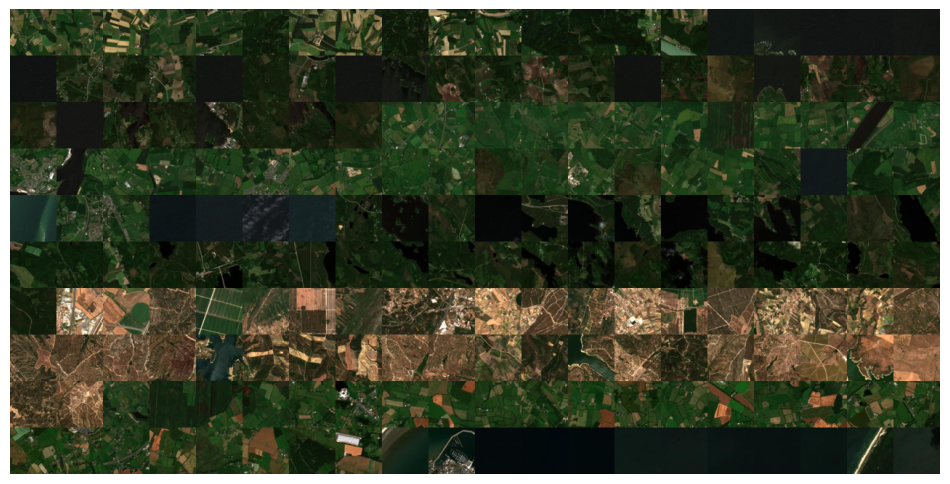

In [46]:
def generate_image_grid(directory, grid_size=(20, 10), image_size=(64, 64)):
    # Get list of image files
    image_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.jpg')]

    # Load images and resize them
    images = [Image.open(img).resize(image_size) for img in image_files[:grid_size[0] * grid_size[1]]]

    # Create a blank canvas for the grid
    grid_width = grid_size[0] * image_size[0]
    grid_height = grid_size[1] * image_size[1]
    grid_image = Image.new('RGB', (grid_width, grid_height))

    # Paste images into the grid
    for i, img in enumerate(images):
        x = (i % grid_size[0]) * image_size[0]
        y = (i // grid_size[0]) * image_size[1]
        grid_image.paste(img, (x, y))

    # Display the grid
    plt.figure(figsize=(12, 7))
    plt.imshow(grid_image)
    plt.axis('off')
    plt.show()

# Example usage
directory = r'C:\Users\isaac\Desktop\BigEarthTests\Subsets\50%\CombinedRGBImagesJPG'
generate_image_grid(directory)

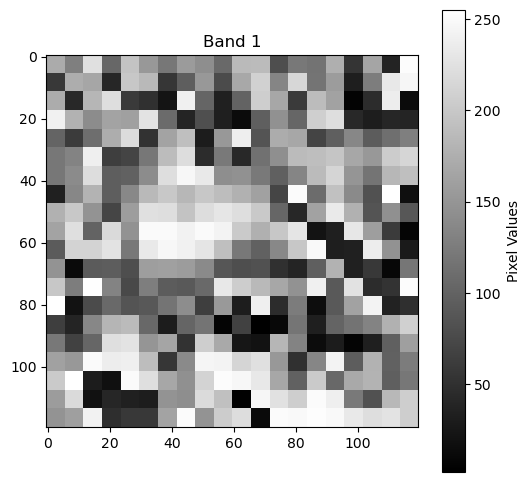

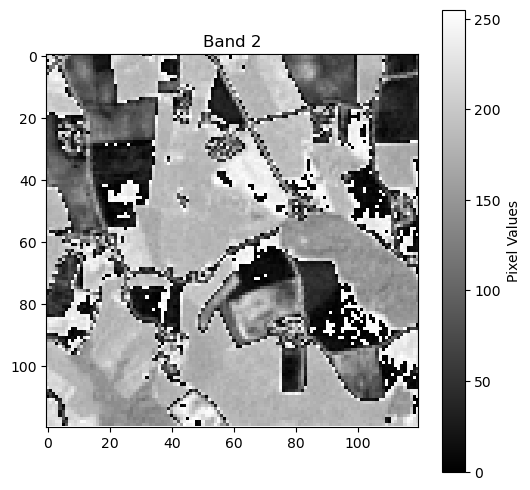

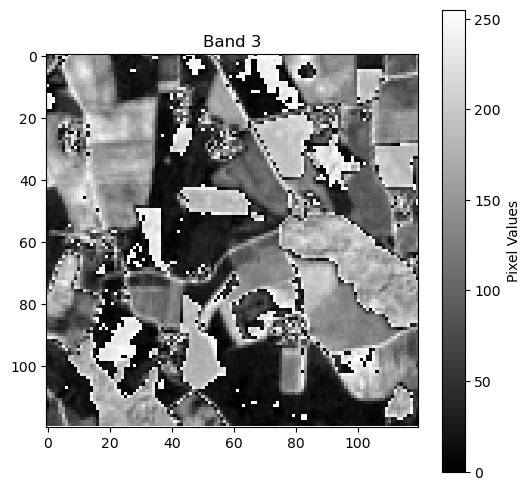

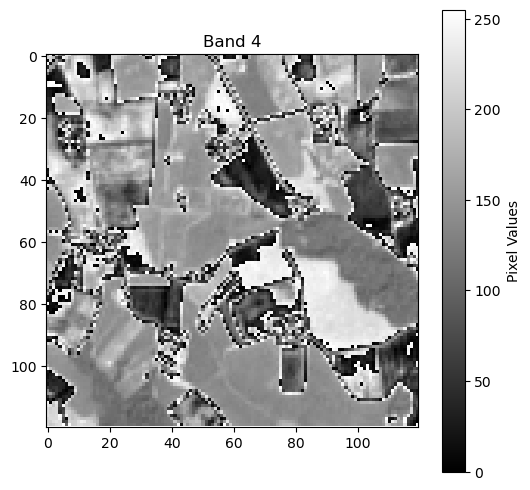

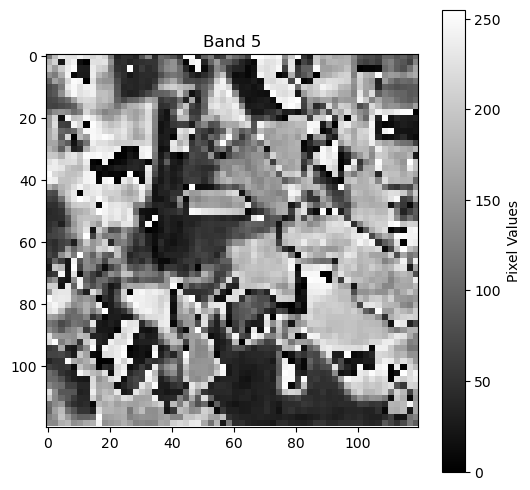

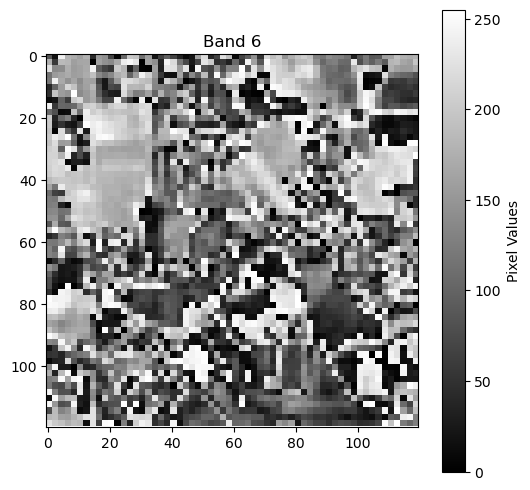

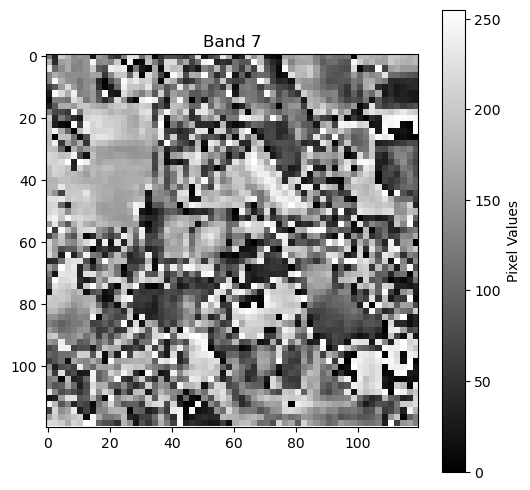

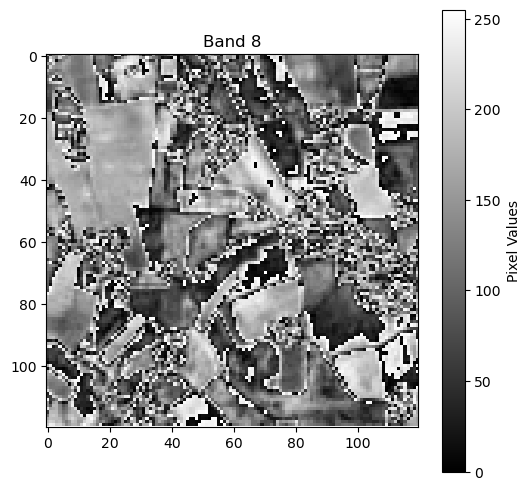

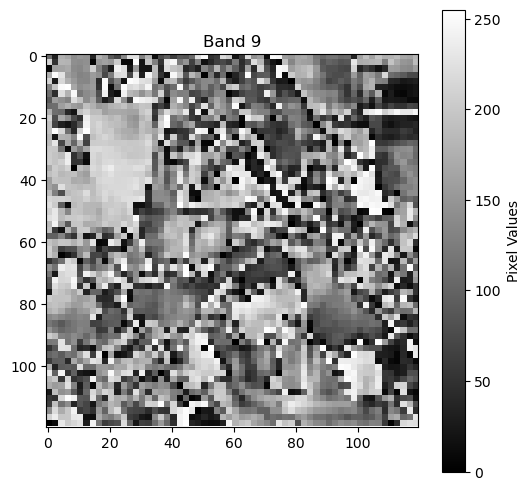

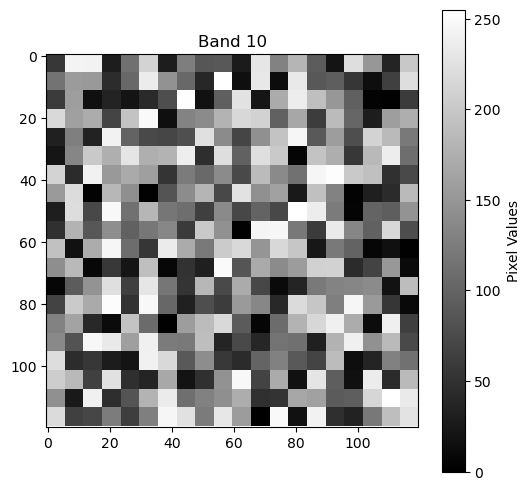

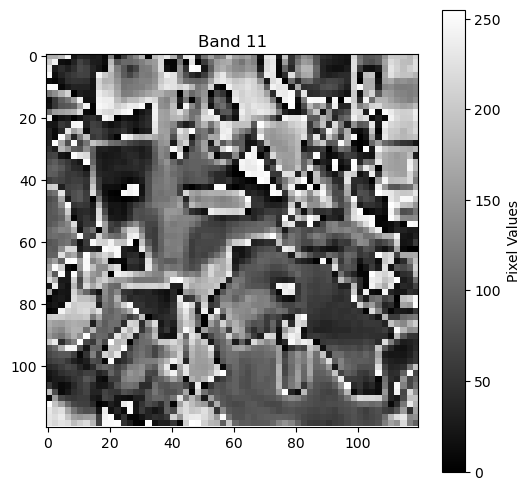

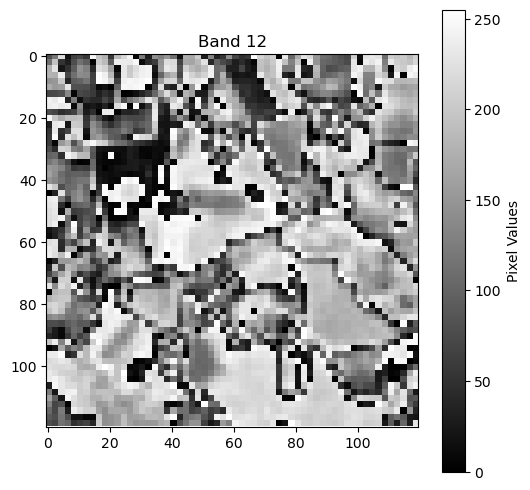

In [17]:
def display_tiff_bands(tiff_file_path):
    with rasterio.open(tiff_file_path) as src:
        # Get the number of bands
        num_bands = src.count

        # Loop through each band and display it
        for band in range(1, num_bands + 1):
            band_data = src.read(band)
            plt.figure(figsize=(6, 6))
            plt.imshow(band_data, cmap='gray')
            plt.title(f'Band {band}')
            plt.colorbar(label="Pixel Values")
            plt.show()

# Example usage
tiff_file_path = r'C:\Users\isaac\Desktop\BigEarthTests\OnePBigEarthNetCopySubsets2\50_percent\CombinedImages\S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP\S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_29_59.tif'
display_tiff_bands(tiff_file_path)

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

def display_rgb_image(tiff_file_path):
    with rasterio.open(tiff_file_path) as src:
        # Read the red, green, and blue bands
        red = src.read(4)
        green = src.read(3)
        blue = src.read(2)
        
        # Normalize each band to the range 0-1
        red = red.astype(np.float32)
        green = green.astype(np.float32)
        blue = blue.astype(np.float32)
        
        red /= np.max(red)
        green /= np.max(green)
        blue /= np.max(blue)
        
        # Stack the bands into an RGB image
        rgb = np.dstack((red, green, blue))
        
        # Display the RGB image
        plt.figure(figsize=(10, 10))
        plt.imshow(rgb)
        plt.title('RGB Image')
        plt.axis('off')
        plt.show()

# Example usage
tiff_file_path = r'C:\Users\isaac\Desktop\BigEarthTests\OnePBigEarthNetCopySubsets2\50_percent\CombinedImages\S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP\S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_29_59.tif'

SyntaxError: incomplete input (2846549667.py, line 32)